## Assigment 2

## 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import math
import operator
import matplotlib.pyplot as plt
import matplotlib as mpl

## Read File given a delimeter

In [3]:
def readFile(trainFile,seperator=",",sample=False):
    try:
        data=pd.read_csv(trainFile, sep=seperator, header=None)
        if sample:
            data=data.sample(frac=1)
        return data.values
    except:
        print("Error reading training data file")

## Distance Measure

``` p=1 for manhattan```

```p=2 for Euclidean (default) ```

In [4]:
def distMeasure(dataset,testdataset,targetIndex,p):
    n=len(testdataset)
    dist=0
    for i in range(n):
        if i==targetIndex:continue
        dist+=math.pow(abs(dataset[i]-testdataset[i]),p);
    return math.pow(dist,1/p)

## Train Test split

In [5]:
def splitTrainTest(data,percent):
    total=len(data)
    trainTotal=int(total*percent*0.01)
    testTotal=total-trainTotal
    return (data[0:trainTotal],data[trainTotal:total])

## K nearest neighbour Algorithm

In [6]:
def KNNAlgo(train,testRecord,k,targetIndex,p):
    dists={}
    count=0
    for trainRecord in train:
        dist=distMeasure(trainRecord,testRecord,targetIndex,p)
        dists[(str(trainRecord),trainRecord[targetIndex],count)]=dist
        count+=1
    sortedDict= sorted(dists.items(), key=operator.itemgetter(1))
    labelDict={}
    for i in range(k):
        if sortedDict[i][0][1] in labelDict.keys():
            labelDict[sortedDict[i][0][1]]+=1
        else:
            labelDict[sortedDict[i][0][1]]=1
    return max(labelDict.items(),key=operator.itemgetter(1))[0]
            

In [7]:
def predict(train,test,k,targetIndex,p,dataType="robot"):
    count=0
    TP=0
    TN=0
    FP=0
    FN=0
    totalP=0
    totalN=0
    if dataType=="robot":
        for testRecord in test:
            predicted=KNNAlgo(train,testRecord,k,targetIndex,p)
            actual=testRecord[targetIndex]
            if actual==0:
                totalP+=1
            elif actual==1:
                totalN+=1
            if actual==predicted:
                count+=1
                if predicted==0:
                    TP+=1
                else:
                    TN+=1
        FP=totalN-TN
        FN=totalP-TP
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        f1Val=2*recall*precision/(recall+precision)
        accuracy=count*100/len(test)
        return (accuracy,precision,recall,f1Val)
    #iris
    else:
        for testRecord in test:
            predicted=KNNAlgo(train,testRecord,k,targetIndex,p)
            actual=testRecord[targetIndex]
            if actual==predicted:
                count+=1
        return ((count/len(test)),1)

In [8]:
def trainAndPredict(trainFile,percent,k,targetIndex,dataType,p=2):
    if dataType=="robot":
        data=readFile(trainFile," ")
        data=np.delete(data, 0, 1)
        data=np.delete(data, 7, 1)
        targetIndex=0
    elif dataType=="iris":
        data=readFile(trainFile)
    else:
        print("Invalid data type : expected iris or robot")
        return   
    train,test=splitTrainTest(data,percent)
    return predict(train,test,k,targetIndex,p,dataType)

***

## Part-1 KNN

### 1. Robot-1

In [9]:
matrix=trainAndPredict("RobotDataset/Robot1",80,7,1,"robot")
print("=================================")
print("Accuracy= ",matrix[0])
print("Precision= ",matrix[1])
print("Recall= ",matrix[2])
print("F1-Score= ",matrix[3])

Accuracy=  84.0
Precision=  0.5
Recall=  1.0
F1-Score=  0.6666666666666666


### 1. Robot-2

In [10]:
matrix=trainAndPredict("RobotDataset/Robot2",80,7,1,"robot")
print("=================================")
print("Accuracy= ",matrix[0])
print("Precision= ",matrix[1])
print("Recall= ",matrix[2])
print("F1-Score= ",matrix[3])

Accuracy=  92.0
Precision=  0.875
Recall=  1.0
F1-Score=  0.9333333333333333


### 1. Iris

In [11]:
trainAndPredict("Iris/Iris.csv",80,7,4,"iris")

(0.9629629629629629, 1)

### 2. "Accuracy" vs "K" graph KNN Algorithm

In [12]:
mpl.rcParams.update(mpl.rcParamsDefault)
def drawGraph(trainFile,percent,targetIndex,dataType,title=None):
    accuracyList1=[]
    accuracyList2=[]
    if dataType=="robot":
        for i in range(1,18,2):
            matrix1=trainAndPredict(trainFile,percent,i,targetIndex,"robot")
            matrix2=trainAndPredict(trainFile,percent,i,targetIndex,"robot",1)
            accuracyList1.append(matrix1[0])
            accuracyList2.append(matrix2[0])
    elif dataType=="iris":
        for i in range(1,18,2):
            matrix1=trainAndPredict(trainFile,percent,i,targetIndex,"iris")
            matrix2=trainAndPredict(trainFile,percent,i,targetIndex,"iris",1)
            accuracyList1.append(matrix1[0])
            accuracyList2.append(matrix2[0])
    else:
        print("Invalid data type : expected iris or robot")
        return
    plt.title(title)
    plt.xlabel("number of neighbours (K)")
    plt.ylabel("Accuracy (in percent)")
    plt.plot(range(1,18,2), accuracyList1,color="orange", linewidth=2.5, label="Euclidean")
    plt.plot(range(1,18,2), accuracyList2,color="green", linewidth=2.5, label="Manhattan")
    plt.legend()
    plt.grid(True)
    plt.show()
    

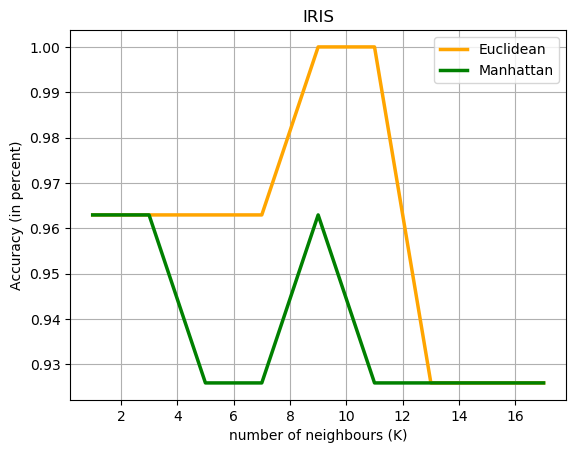

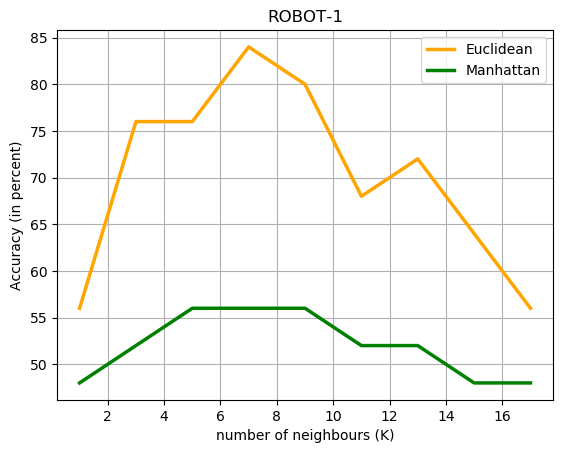

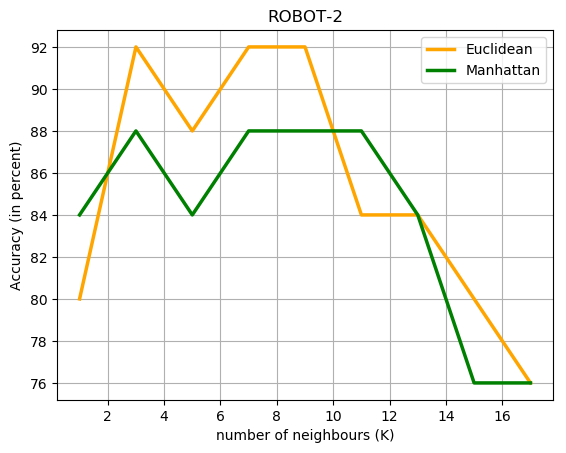

In [13]:
drawGraph("Iris/Iris.csv",80,4,"iris","IRIS")
drawGraph("RobotDataset/Robot1",80,1,"robot","ROBOT-1")
drawGraph("RobotDataset/Robot2",80,1,"robot","ROBOT-2")

## Comparision with scikit learn

In [14]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix  

def skLearn(trainFile,trainDataPercent,delimeter,unwantedCols,NANCols,k,targetIndex,avg=None):
    if trainDataPercent==100:
        print("No Validation data (Training percent should be less than 100)")
        return
    data=readFile(trainFile,delimeter)
#     data=data.sample(frac=1)
    
    le = LabelEncoder()
    X=None
    
    for i in NANCols:
        data[:,i]=le.fit_transform(data[:,i])
    
    Y=data[:,targetIndex]
    Y=Y.astype('int')
    X=np.delete(data,unwantedCols,axis=1)
    trainX,testX,trainY,testY=train_test_split(X,Y,test_size=(100-trainDataPercent)/100,shuffle=False)
    
    #specify p=1,2,3
    tree = KNeighborsClassifier(n_neighbors=k,p=2)      
    tree.fit(trainX, trainY)  
    y_pred = tree.predict(testX)  
    matrix=precision_recall_fscore_support(testY,y_pred,average=avg)
    confMat=confusion_matrix(testY,y_pred)
#     print(matrix)
    print("=======================================================")
#     print(confMat)
    print("Accuracy= ",accuracy_score(testY,y_pred))
    print(classification_report(testY, y_pred))
#     print("=======================================================")
#     print("Scikit Learn Results ")
#     print("Trained on %d percent of Training data " %(trainDataPercent))
#     print("Total DataSets: ",len(data))
#     print("Training DataSets: ",int(len(data)*(trainDataPercent/100)+0.5))
#     print("Validation DataSets: ",int(len(data)*(1-trainDataPercent/100)+0.5))
#     print("Truelly Validated: ",confMat[0][0]+confMat[1][1])
#     print("Falsely Validated: ",confMat[0][1]+confMat[1][0])
#     print("=======================================================")
#     print("Accuracy = ", accuracy_score(testY,y_pred))
#     print("Precision = ", matrix[0])
#     print("Recall = ", matrix[1])
#     print("F1-Score = ", matrix[2])

In [15]:
print("Accuracy and measurement matrix for Robot1")
skLearn("RobotDataset/Robot1",80," ",[0,1,8],[],7,1,"binary")
print("Accuracy and measurement matrix for Robot2")
skLearn("RobotDataset/Robot2",80," ",[0,1,8],[],7,1,"binary")
print("Accuracy and measurement matrix for Iris")
skLearn("Iris/Iris.csv",80,",",[4],[4],7,4)


Accuracy and measurement matrix for Robot1
Accuracy=  0.8
              precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       1.00      0.76      0.86        21

   micro avg       0.80      0.80      0.80        25
   macro avg       0.72      0.88      0.74        25
weighted avg       0.91      0.80      0.82        25

Accuracy and measurement matrix for Robot2
Accuracy=  0.92
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       1.00      0.82      0.90        11

   micro avg       0.92      0.92      0.92        25
   macro avg       0.94      0.91      0.92        25
weighted avg       0.93      0.92      0.92        25

Accuracy and measurement matrix for Iris
Accuracy=  0.9629629629629629
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.90      0.95      

## Part 2- Naive Bayes classifier

* ID - A unique identifier 

**Indexing**
* Age - 0

* Number of years of experience - 1

* Annual Income - 2

* ZIPCode - 3

* Family size - 4 

* Avgerage spending per month - 5

* Education Level. 1: 12th; 2: Graduate; 3: Post Graduate  - 6

* Mortgage Value of house if any - 7

* Did this customer accept the personal loan offered in the last campaign? --  **Output label - 8**

* Does the customer have a securities account with the bank? - 9

* Does the customer have a certificate of deposit (CD) account with the bank? - 10

* Does the customer use internet banking facilities? - 11

* Does the customer uses a credit card issued by UniversalBank? - 12


### Normal Distribution

In [16]:
def getProbabilityNormal(x, mean, std):
    exp = math.exp(-(math.pow(x-mean,2)/(2*math.pow(std,2))))
    return (1 / (math.sqrt(2*math.pi) * std)) * exp

In [159]:
import pprint
def bayesClassifier(trainFile,percent,categoricalList=[6,9,10,11,12],numericalList=[0,1,2,4,5,7]):
    data=pd.read_csv(trainFile,",",header=0).sample(frac=1).values
    data=np.delete(data,0,axis=1)

    train,test=splitTrainTest(data,percent)
    labelZeroOne=np.unique(train[:,8],return_counts=True)
    

    zeroRecords=np.where(train[:,8]==0)
    oneRecords=np.where(train[:,8]==1)

    totalZeroRecords=len(zeroRecords[0])
    totalOneRecords=len(oneRecords[0])
    # print(totalOneRecords,totalZeroRecords)
    # print(labelZeroOne)
    
    ############################################################################
    #Calculate all the possible probabilities of all the attributes for each hypothesis
    
    
    ########## Categorical Attr start ##########
    featureIndexDict={}

    # {3:{0: {1:count,2:,3:}
    #     1: {1:,2:,3:}
    #     }
    #}
    
    for i in categoricalList:
        CCardUser={}
        CCardUserONE=np.unique(train[oneRecords[0],i],return_counts=True)
        # print("CCardUserONE",CCardUserONE)
        CCardUser[1]={value:CCardUserONE[1][index] for index,value in enumerate(CCardUserONE[0])}

        CCardCUserZERO=np.unique(train[zeroRecords[0],i],return_counts=True)
        # print("CCardCUserZERO",CCardCUserZERO)
        CCardUser[0]={value:CCardCUserZERO[1][index] for index,value in enumerate(CCardCUserZERO[0])}
        featureIndexDict[i]=CCardUser
    # pprint.pprint(featureIndexDict)
    
    ########## Categorical Attr end ##########
    
    ########## Numerical Attr start ##########
    
    meanStdDictIndex={}
    
    # {0:{0: {"mean":,"std":}
    #     1: {"mean":,"std":}
    #     }
    # }
    
    for i in numericalList:
        myDict={}
        ageMeanONE=np.mean(train[oneRecords[0],i])
        # print("ageMeanONE ",ageMeanONE)
        ageMeanZERO=np.mean(train[zeroRecords[0],i])
        # print("ageMeanZERO ",ageMeanZERO)
        ageStdONE=np.std(train[oneRecords[0],i])
        # print("ageStdONE ",ageStdONE)
        ageStdZERO=np.std(train[zeroRecords[0],i])
        myDict[1]={"mean":ageMeanONE,"std":ageStdONE}
        myDict[0]={"mean":ageMeanZERO,"std":ageStdZERO}
        meanStdDictIndex[i]=myDict
        # print("ageStdZERO ",ageStdZERO)
    # pprint.pprint(meanStdDictIndex)
    ########## Numerical Attr end ##########
    ############################################################################
    
    priorOne=totalOneRecords/(totalZeroRecords+totalOneRecords)
    priorZero=totalZeroRecords/(totalZeroRecords+totalOneRecords)
    priors={0:priorZero,1:priorOne}
    totalOneZeroRecords={0:totalZeroRecords,1:totalOneRecords}

    ############################ Prediction ###################################
    count=0
    answers={}
    TP=0
    TN=0
    FP=0
    FN=0
    totalP=0
    totalN=0
    for testR in test:
        for i in [0,1]:
            numerical=1
            categorical=1
            for index in numericalList:
                numerical*=getProbabilityNormal(testR[index],meanStdDictIndex[index][i]["mean"],meanStdDictIndex[index][i]["std"])
            for index in categoricalList:
                categorical*=featureIndexDict[index][i][testR[index]]/totalOneZeroRecords[i]
            ans=categorical*numerical*priors[i]
            answers[i]=ans
    #     print(answers)
        actual=testR[8]
        if actual==0:
            totalP+=1
        if actual==1:
            totalN+=1
        if answers[1]>answers[0] and testR[8]==1:
            count+=1
            TN+=1
        elif answers[1]<=answers[0] and testR[8]==0:
            count+=1
            TP+=1
    FP=totalN-TN
    FN=totalP-TP
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1Val=2*recall*precision/(recall+precision)
#     print(len(test))
#     print(count)
    accuracy=count/len(test)
    return (accuracy,precision,recall,f1Val)
    
    ############################ Prediction end ###################################



In [160]:
matrix=bayesClassifier("LoanDataset/data.csv",80,[6,9,10,11,12],[0,1,2,4,5,7])
print("=================================")
print("Accuracy= ",matrix[0])
print("Precision= ",matrix[1])
print("Recall= ",matrix[2])
print("F1-Score= ",matrix[3])

Accuracy=  0.9166666666666666
Precision=  0.96625
Recall=  0.9415347137637028
F1-Score=  0.9537322640345467


## Part-3 Regression

### 1. Predicting probabiliy of getting admit

In [151]:
def predictProbAdmit(trainFile,percent,targetIndex=8):
    data=pd.read_csv(trainFile).values
    train,test=splitTrainTest(data,percent)
    testY=test[:,targetIndex]
    test[:,0]=1
    train[:,0]=1
    
    y=np.transpose(np.matrix(train[:,targetIndex]))
    train=np.delete(train,targetIndex,axis=1)
    test=np.delete(test,targetIndex,axis=1)
    
    X=np.matrix(train)
    XT=np.transpose(X)
    inverse=np.linalg.inv(XT*X)
    coefficents=inverse*XT*y
    # print(coefficents)
    predicted=np.array(np.matrix(test)*coefficents)
    print("========================")
    print("Original ", "Predicted")
    print("========================")
    for actual,pre in zip(testY,predicted):
        print(actual,"   ",pre[0])

In [152]:
predictProbAdmit("AdmissionDataset/data.csv",80,8)

Original  Predicted
0.48     0.5821223877616327
0.47     0.45599721510630753
0.53     0.6192326927922606
0.7     0.5531126049635834
0.78     0.7441106003715638
0.61     0.6585151392626817
0.74     0.6982046625663304
0.71     0.7484359734470475
0.93     0.9080769913300264
0.61     0.5556663994242895
0.53     0.6845057560781755
0.71     0.7439977347688524
0.8     0.7881402527802843
0.9     0.9068660446373871
0.96     0.9662003986426574
0.74     0.7151647309396764
0.94     0.9379563251289611
0.69     0.7740315457040686
0.82     0.8053707218839301
0.46     0.4398545801900546
0.91     0.9149936999482482
0.65     0.7065207632105628
0.71     0.795501871338779
0.42     0.6254980271724156
0.79     0.8351973598493889
0.91     0.8788002997458608
0.87     0.8549530388676725
0.73     0.6188927799077478
0.78     0.7892538266353268
0.81     0.7404605188594753
0.57     0.6621711375601607
0.69     0.6346799175864936
0.87     0.8144943613561574
0.56     0.7014627938598357
0.88     0.8640768179526406
0.8

### Comparision with scikit learn linear regression

In [155]:
from sklearn.linear_model import LinearRegression

def skLearnReg(trainFile,trainDataPercent,unwantedCols,NANCols,targetIndex):
    if trainDataPercent==100:
        print("No Validation data (Training percent should be less than 100)")
        return
    data=pd.read_csv(trainFile).values
#     data=data.sample(frac=1)
    
    le = LabelEncoder()
    X=None
    for i in NANCols:
        data[:,i]=le.fit_transform(data[:,i])
    
    Y=data[:,targetIndex]
    X=np.delete(data,unwantedCols,axis=1)
    trainX,testX,trainY,testY=train_test_split(X,Y,test_size=(100-trainDataPercent)/100,shuffle=False)
    
    model = LinearRegression()      
    reg=model.fit(trainX, trainY)  
#     print(reg.coef_)
#     print(reg.intercept_)
    print("========================")
    print("Original ", "Predicted")
    print("========================")
    for actual,pred in zip(testY,reg.predict(testX)):
        print(actual,"   ",pred)

In [156]:
skLearnReg("AdmissionDataset/data.csv",80,[0,8],[],8)

Original  Predicted
0.48     0.5821223877613795
0.47     0.45599721510605806
0.53     0.6192326927919809
0.7     0.5531126049633159
0.78     0.7441106003712523
0.61     0.6585151392624113
0.74     0.6982046625660501
0.71     0.7484359734467829
0.93     0.9080769913297302
0.61     0.5556663994240334
0.53     0.6845057560778804
0.71     0.7439977347685809
0.8     0.7881402527800025
0.9     0.9068660446370846
0.96     0.9662003986423535
0.74     0.7151647309393914
0.94     0.9379563251286522
0.69     0.7740315457037901
0.82     0.805370721883639
0.46     0.4398545801898104
0.91     0.9149936999479471
0.65     0.7065207632102783
0.71     0.7955018713384874
0.42     0.6254980271721278
0.79     0.8351973598490803
0.91     0.8788002997455662
0.87     0.8549530388673783
0.73     0.6188927799074777
0.78     0.7892538266350284
0.81     0.7404605188591562
0.57     0.6621711375598629
0.69     0.6346799175862183
0.87     0.8144943613558677
0.56     0.7014627938595641
0.88     0.8640768179523501
0.8